<a href="https://colab.research.google.com/github/saugatapaul1010/CIFAR10-ENET-B5/blob/main/CIFAR_10_EfficientNetB5_Version_2_Reduce_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries, Connect With G-Drive, Check GPU Availability

In [1]:
#Importing all the libraries
from keras.backend import sigmoid
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.utils import to_categorical
import albumentations as albu
from sklearn.metrics import accuracy_score
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D, LeakyReLU, SpatialDropout2D 
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, History, TensorBoard, Callback, LearningRateScheduler
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import math
from keras.models import load_model
import gc
import itertools
import os
import tempfile

In [2]:
#Mounting Gdrive
from google.colab import drive
drive.mount('/gdrive')
model_save_path = "/gdrive/My Drive/CIFAR-10-MODELS"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
#Check GPU Availability
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

os.environ["CUDA_VISIBLE_DEVICES"]="0"

TF version: 2.9.1
GPU is NOT AVAILABLE
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6653554495229461190
xla_global_id: -1
]


# Helper Functions For Data Visualization and Data Transformations

In [4]:
def load_data():
    """
    Helper function to prepare the train, vaid, test datasets, for CIFAR-10.
    """
    (X, y), (X_test, y_test) = cifar10.load_data()
    st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1947)

    #Splitting X into X_train, X_val. Keeping X_Test only for testing model's performance on unseen data.
    for train_index, val_index in st.split(X, y):
        X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]

    print("The number of training data : ", X_train.shape[0])
    print("The number of validation data : ", X_val.shape[0])
    print("The number of test data : ", X_test.shape[0])

    del X, y

    return X_train, y_train, X_val, y_val, X_test, y_test

def plot_data(class_label_list):
    """
    Helper function to plot sample images from the training set.
    """
    NUM_CLASSES = len(class_label_list)
    class_plotted = np.random.choice(range(len(class_label_list)), NUM_CLASSES, replace = False)

    for i in range(len(class_plotted)):
        image_samples = X_train[y_train.reshape(-1) == class_plotted[i]][:10]
        fig, ax = plt.subplots(nrows = 1, ncols = 10,figsize = (8,8))
        fig.suptitle("Label : %d, Class : %s" % (class_plotted[i], class_label_list[class_plotted[i]]), y = .6)
        for j in range(10):
            ax[j].imshow(image_samples[j])
            ax[j].axis('off')  
        fig.tight_layout()
    plt.show()

    return NUM_CLASSES

# Converting class vectors to binary class matrices
def normalize_images(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Helper function to normalize the datasets"
    """
    y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)
    y_val = keras.utils.to_categorical(y_val, NUM_CLASSES)

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_val = X_val.astype('float32')
    X_train /= 255
    X_val /= 255
    X_test /= 255

    print("Images Normalized")

    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
#Load Dataset CIFAR-10
X_train, y_train, X_val, y_val, X_test, y_test = load_data()

170498071/170498071 [==============================] - 2s 0us/step
The number of training data :  40000
The number of validation data :  10000
The number of test data :  10000


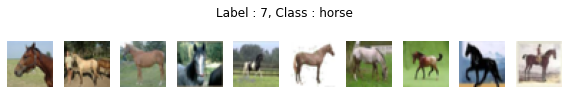

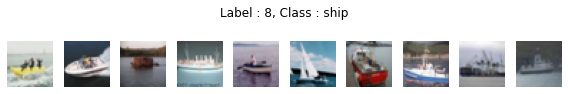

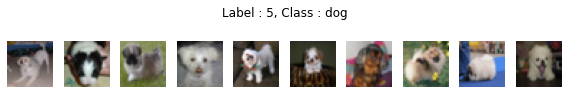

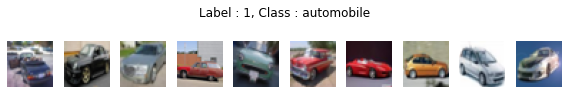

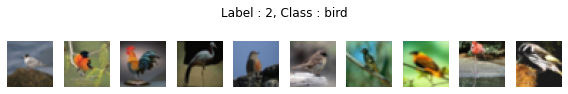

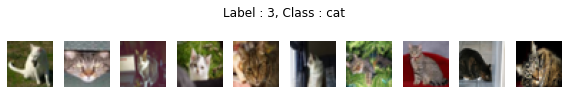

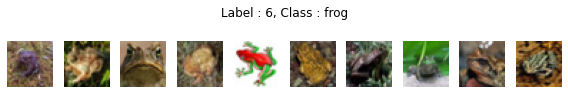

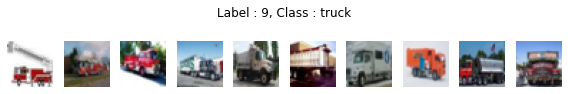

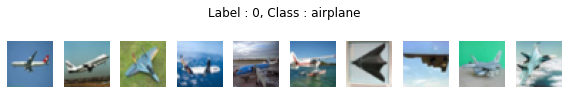

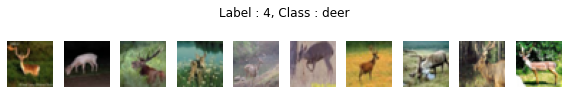

In [6]:
#Plot the data
class_label_list = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = plot_data(class_label_list)

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = normalize_images(X_train, y_train, X_val, y_val, X_test, y_test)

Images Normalized


# Helper Functions Required For Model Training and Evaluation

In [8]:
class SwishActivation(Activation):
    """Custom Actvation Function. 
    Reference : https://iq.opengenus.org/swish-activation-function/, 
                https://medium.com/@neuralnets/swish-activation-function-by-google-53e1ea86f820
    """    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

class CosineAnnealingScheduler(Callback):
    """Cosine annealing scheduler Callback
    implemented using the Keras Callback class.
    References: https://paperswithcode.com/method/cosine-annealing
    """

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)


def adjust_learning_rate(epoch):
    """This function is used if we want to manually decrease 
    the learning rate after specific epochs.
    """
    lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"]
    if epoch >= 10:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 10
    if epoch >= 20:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 100
    if epoch >= 30:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 1000
    if epoch >= 40:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 10000
    if epoch >= 50:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 100000
    if epoch >= 60:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 1000000
    if epoch >= 70:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 10000000
    if epoch >= 80:
        lr = input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] / 100000000
    return lr

def callbacks_list(input_params):
    """
    This function is used to define custom callbacks. Any new callbacks
    that are to be added to the model must be defined in this function
    and returned as a list of callbacks.
    """    
    base_checkpoint_folder = '/gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_{}'.format(input_params["MODEL_NUMBER"])
    checkpoint_filepath = base_checkpoint_folder + '-{epoch:02d}-{val_accuracy:.2f}.h5'    
    checkpoint = ModelCheckpoint(checkpoint_filepath,
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=False,
                                 mode='max')
    
    reduce_learning_rate = ReduceLROnPlateau(monitor = input_params['REDUCE_LR_MONITOR'], 
                                             mode = input_params['REDUCE_LR_MODE'] , 
                                             patience = input_params['REDUCE_LR_PATIENCE'], 
                                             factor = input_params['REDUCE_LR_DECAY'], 
                                             min_lr = input_params['REDUCE_MIN_LR'], 
                                             verbose = 1)
    
    early_stop = EarlyStopping(monitor = input_params['EARLY_STOP_MONITOR'], 
                               mode = input_params['EARLY_STOP_MODE'], 
                               patience = input_params['EARLY_STOP_PATIENCE'], 
                               restore_best_weights = True, 
                               verbose = 1)
    
    history = History()

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/gdrive/My Drive/tf_logs")

    #!tensorboard --logdir=/gdrive/My Drive/tf_logs/ --bind_all
    callbacks = [checkpoint, reduce_learning_rate, history, early_stop, tensorboard_callback]

    if input_params["LR_SCHEDULER"] == 'CosineAnnealing':
        callbacks.append(CosineAnnealingScheduler(T_max=input_params['TRAIN_EPOCHS'], eta_max=0.05, eta_min=4e-4))
    if input_params["LR_SCHEDULER"] == 'LearningRateScheduler':
        callbacks.append(LearningRateScheduler(adjust_learning_rate))
        
    return callbacks

def evaluate_model(model, X_test, y_test, X_train, y_train, X_val, y_val):
    """This function is used to evaluate the models
    performance across different datasets
    """
    loss, acc = model.evaluate(X_train, y_train)
    print("Training Accuracy: {}%".format(np.round(acc*100,2)))
    print("Training Loss: {}\n".format(np.round(loss,2)))

    loss, acc = model.evaluate(X_val, y_val)
    print("Validation Accuracy: {}%".format(np.round(acc*100,2)))
    print("Validation Loss: {}\n".format(np.round(loss,2)))

    loss, acc = model.evaluate(X_test, y_test)
    print("Test Accuracy: {}%".format(np.round(acc*100,2)))
    print("Test Loss: {}\n".format(np.round(loss,2)))


def plot_cm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, LABELS=class_label_list):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names = LABELS

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def train_val_loss(history):
    """
    Function to check train vs validation loss/
    accuracy across all epochs.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Set')
    plt.plot(epochs_range, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Efficient B5 Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Set')
    plt.plot(epochs_range, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Efficient B5 Model Loss')

    plt.tight_layout()
    plt.show()

# Experiment : **1**

1. Changed the design of the fully connected layers, than the one used before
2. Used ImageDataGenerator for image augmentation- used roation, horizontal flip, width and height shift factors
3. Using a strong decay factor of 0.5 for ReduceLROnPlateau


### Define Model Hyperparameters:

In [ ]:
#Define the Hyperparameters for each models
input_params = dict()
input_params['EARLY_STOP_MONITOR'] = 'val_loss'
input_params['EARLY_STOP_MODE'] = 'min'
input_params['EARLY_STOP_PATIENCE'] = 6
input_params['REDUCE_LR_MONITOR'] = 'val_loss'
input_params['REDUCE_LR_MODE'] = 'min'
input_params['REDUCE_LR_PATIENCE'] = 2
input_params['REDUCE_LR_DECAY'] = 0.5
input_params['LR_SCHEDULER'] =  'None' #'LearningRateScheduler'  #'CosineAnnealing'
input_params['REDUCE_MIN_LR'] = 0.0000001
input_params['MINIBATCH_SIZE'] = 64
input_params['TRAIN_EPOCHS'] = 150
input_params['ACTIVATION_TYPE'] = "RELU" #'RELU'
input_params['NUM_CLASSES'] = NUM_CLASSES
input_params["MODEL_NUMBER"] = 1 #ExperimentNumber
input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] = 0.001
input_params["OPTIMIZER"] = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
input_params["CALLBACKS"] = callbacks_list(input_params)
input_params["EVAL_METRIC"] = 'accuracy'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Define Model Architecture:

In [ ]:
def build_model_1(input_params):
    """
    This function is used to build the model architecture. Here I am adding 2 
    fully-connected layers to B5. We will modify this function to change the 
    model architecture during each training pass.
    """

    conv_base = EfficientNetB5(include_top=False, input_shape=(32,32,3), weights='imagenet')

    #Setting al layers trainable == True
    for layer in conv_base.layers:
        layer.trainable = True

    activation_type = 'relu'

    # Adding fully-connected layers to B5.
    x = conv_base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation=activation_type)(x) 
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(256, activation=activation_type)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation=activation_type)(x)
    x = layers.Dropout(0.2)(x)  

    # Output layer
    prediction_layer = Dense(input_params['NUM_CLASSES'], activation="softmax")(x)
    model_final = Model(inputs = conv_base.input, outputs = prediction_layer)

    # Define the optimizer and compile the model
    model_final.compile(loss='categorical_crossentropy', 
                        optimizer = input_params["OPTIMIZER"], 
                        metrics = input_params["EVAL_METRIC"])
    return model_final

model_1 = build_model_1(input_params)
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization[0][0]']          
                                                                                              

### Define Model Augmentation Parameters:

In [ ]:
#The below Datagen layer will be used for Image Augmentation
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)

datagen.fit(X_train)

### Start Model Training:

In [ ]:
#Start model training
history_1 = model_1.fit_generator(datagen.flow(X_train, y_train, batch_size = input_params['MINIBATCH_SIZE']),
                                  steps_per_epoch = len(X_train) // input_params['MINIBATCH_SIZE'], 
                                  epochs = input_params['TRAIN_EPOCHS'],
                                  callbacks=input_params["CALLBACKS"],
                                  validation_data= (X_val, y_val),
                                  verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/150
625/625 [==============================] - ETA: 0s - loss: 1.9903 - accuracy: 0.2402
Epoch 1: val_accuracy improved from -inf to 0.14200, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_1-01-0.14.h5
625/625 [==============================] - 127s 158ms/step - loss: 1.9903 - accuracy: 0.2402 - val_loss: 2.4048 - val_accuracy: 0.1420 - lr: 0.0010
Epoch 2/150
625/625 [==============================] - ETA: 0s - loss: 1.5216 - accuracy: 0.4462
Epoch 2: val_accuracy improved from 0.14200 to 0.15200, saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_1-02-0.15.h5
625/625 [==============================] - 95s 152ms/step - loss: 1.5216 - accuracy: 0.4462 - val_loss: 2.2134 - val_accuracy: 0.1520 - lr: 0.0010
Epoch 3/150
625/625 [==============================] - ETA: 0s - loss: 1.2910 - accuracy: 0.5723
Epoch 3: val_accuracy did not improve from 0.15200
625/625 [==============================] - 89s 142ms/step - loss: 1.2910 - accuracy: 0.5723 - val_loss

### Train vs Validation (Loss and Accuracy Graphs):

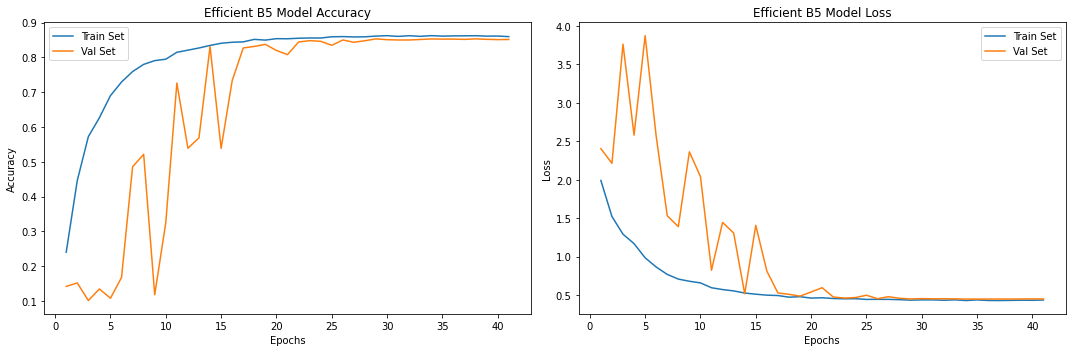

In [ ]:
train_val_loss(history_1)

### Model Evaluation Across All Datasets:

In [ ]:
best_model_path = "/gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_1-29-0.85.h5"
model_1 = load_model(best_model_path)
evaluate_model(model_1, X_test, y_test, X_train, y_train, X_val, y_val)

1250/1250 [==============================] - 49s 34ms/step - loss: 0.3309 - accuracy: 0.8920
Training Accuracy: 89.2%
Training Loss: 0.33

313/313 [==============================] - 17s 41ms/step - loss: 0.4480 - accuracy: 0.8534
Validation Accuracy: 85.34%
Validation Loss: 0.45

313/313 [==============================] - 12s 38ms/step - loss: 0.4665 - accuracy: 0.8511
Test Accuracy: 85.11%
Test Loss: 0.47



### Plot Confusion Matrix -- Training:

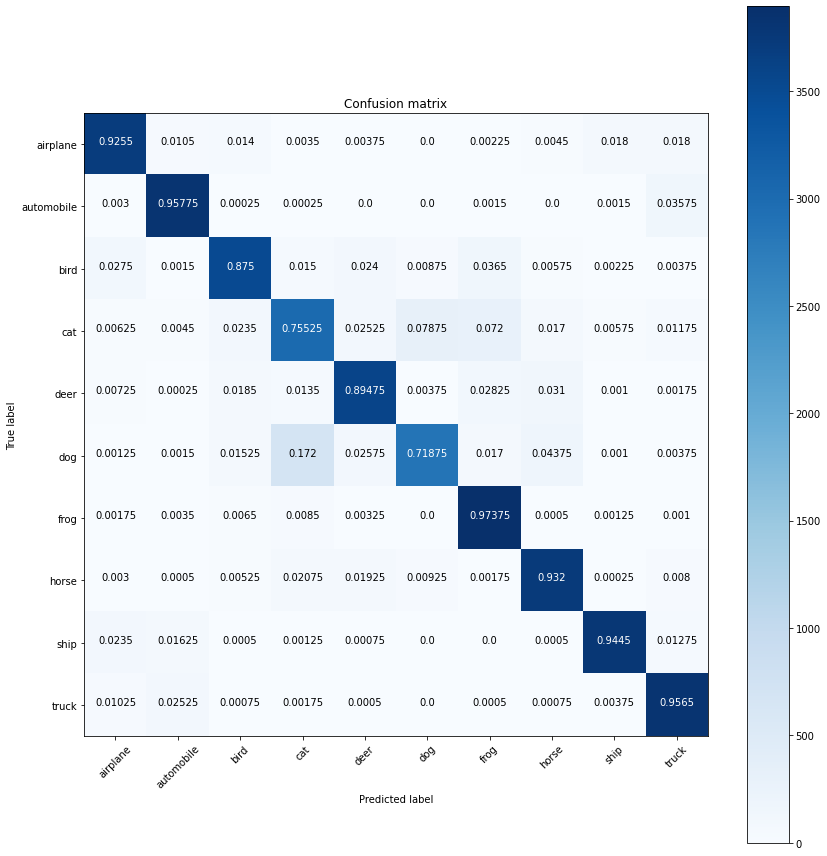

In [ ]:
#Display the confusion matrix for train set
Y_pred = model_1.predict(X_train, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_train, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

### Plot Confusion Matrix -- Validation:

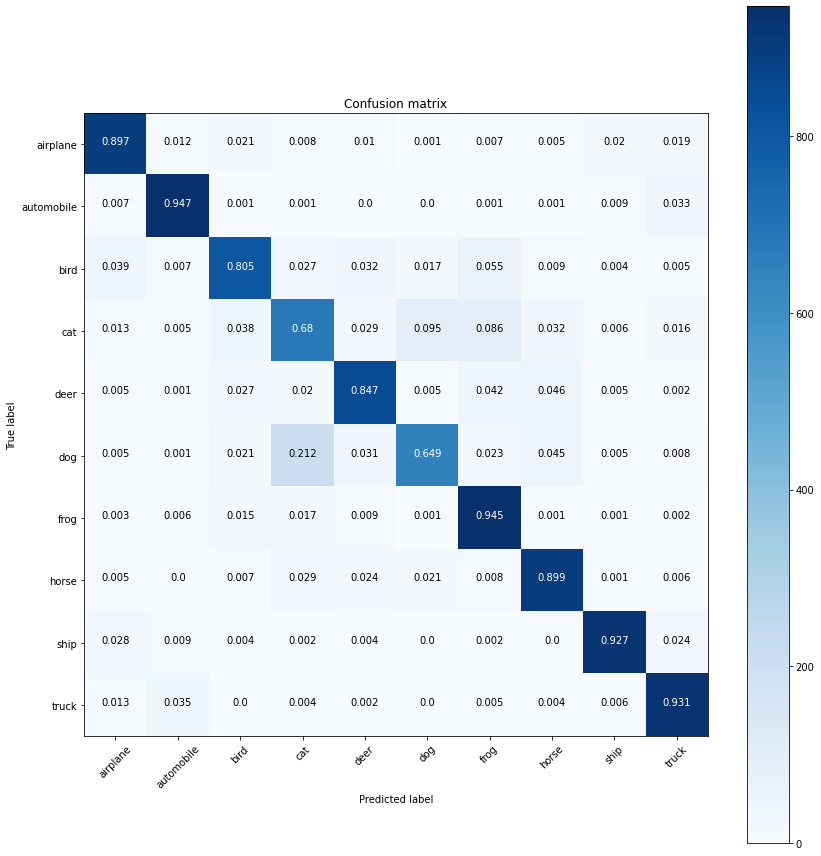

In [ ]:
#Display the confusion matrix for validation set
Y_pred = model_1.predict(X_val, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_val, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

### Plot Confusion Matrix -- Unseen Test Data:

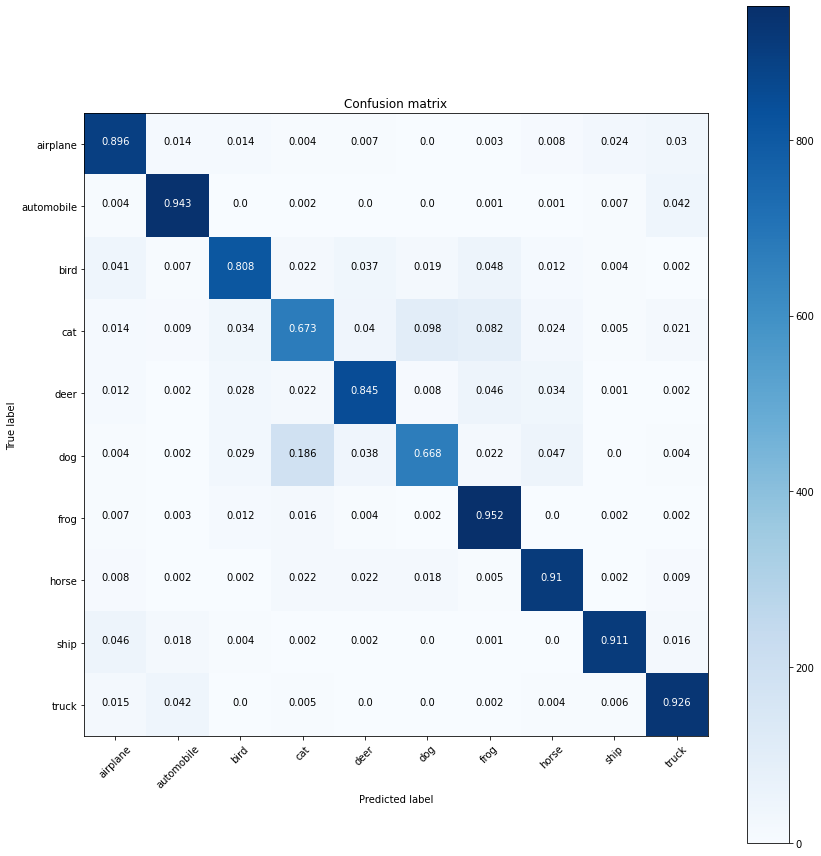

In [ ]:
#Display the confusion matrix for test set
Y_pred = model_1.predict(X_test, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_test, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

# Experiment : **2**

1. Adding regularizer to the dense layers
2. Using proper weight initialization (he-normal for relu activation, glorot_normal for 'softmax' : This method is not giving good results)
3. Including ZOOM as another augmentation parameter
4. Training the model for longer duration so that the learning rate decreases adapatively during the later stages

### Define Model Hyperparameters:

In [ ]:
#Define the Hyperparameters for each models
input_params = dict()
input_params['EARLY_STOP_MONITOR'] = 'val_loss'
input_params['EARLY_STOP_MODE'] = 'min'
input_params['EARLY_STOP_PATIENCE'] = 12
input_params['REDUCE_LR_MONITOR'] = 'val_loss'
input_params['REDUCE_LR_MODE'] = 'min'
input_params['REDUCE_LR_PATIENCE'] = 4
input_params['REDUCE_LR_DECAY'] = 0.5
input_params['LR_SCHEDULER'] =  'None' #'LearningRateScheduler'  #'CosineAnnealing'
input_params['REDUCE_MIN_LR'] = 0.0000001
input_params['MINIBATCH_SIZE'] = 64
input_params['TRAIN_EPOCHS'] = 150
input_params['ACTIVATION_TYPE'] = "RELU" #'RELU'
input_params['NUM_CLASSES'] = NUM_CLASSES
input_params["MODEL_NUMBER"] = 2 #ExperimentNumber
input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] = 0.001
input_params["OPTIMIZER"] = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
input_params["CALLBACKS"] = callbacks_list(input_params)
input_params["EVAL_METRIC"] = 'accuracy'

### Define Model Architecture:

In [ ]:
def build_model_2(input_params):
    """
    This function is used to build the model architecture. Here I am adding 2 
    fully-connected layers to B5. We will modify this function to change the 
    model architecture during each training pass.
    """
    #kernel_regularizer = tf.keras.regularizers.l1(0.01)

    conv_base = EfficientNetB5(include_top=False, input_shape=(32,32,3), weights='imagenet')

    #Setting al layers trainable == True
    for layer in conv_base.layers:
        layer.trainable = True

    activation_type = 'relu'

    # Adding fully-connected with dropout layers to B5.
    x = conv_base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation = activation_type)(x) 
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(256, activation = activation_type)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation = activation_type)(x)
    x = layers.Dropout(0.2)(x)  

    # Output layer
    prediction_layer = Dense(input_params['NUM_CLASSES'], activation="softmax", kernel_regularizer = tf.keras.regularizers.L2(0.01))(x)
    model_final = Model(inputs = conv_base.input, outputs = prediction_layer)

    # Define the optimizer and compile the model
    model_final.compile(loss='categorical_crossentropy', 
                        optimizer = input_params["OPTIMIZER"], 
                        metrics = input_params["EVAL_METRIC"])
    return model_final

model_2 = build_model_2(input_params)
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization[0][0]']          
                                                                                              

### Define Model Augmentation Parameters:

In [ ]:
#The below ImageDataGenerator layer will be used for Image Augmentation
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=15,
                            zoom_range = 0.1,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            vertical_flip=False)

datagen.fit(X_train)

### Start Model Training:

In [ ]:
#Start model training
history_2 = model_2.fit_generator(datagen.flow(X_train, y_train, batch_size = input_params['MINIBATCH_SIZE']),
                                  steps_per_epoch = len(X_train) // input_params['MINIBATCH_SIZE'], 
                                  epochs = input_params['TRAIN_EPOCHS'],
                                  callbacks=input_params["CALLBACKS"],
                                  validation_data= (X_val, y_val),
                                  verbose=1)

Epoch 1/150


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


625/625 [==============================] - ETA: 0s - loss: 1.9975 - accuracy: 0.2901
Epoch 1: saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_2-01-0.12.h5
625/625 [==============================] - 132s 164ms/step - loss: 1.9975 - accuracy: 0.2901 - val_loss: 4.0253 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 2/150
625/625 [==============================] - ETA: 0s - loss: 1.4260 - accuracy: 0.5258
Epoch 2: saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_2-02-0.17.h5
625/625 [==============================] - 98s 158ms/step - loss: 1.4260 - accuracy: 0.5258 - val_loss: 2.2399 - val_accuracy: 0.1697 - lr: 0.0010
Epoch 3/150
625/625 [==============================] - ETA: 0s - loss: 1.1922 - accuracy: 0.6183
Epoch 3: saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_2-03-0.18.h5
625/625 [==============================] - 98s 157ms/step - loss: 1.1922 - accuracy: 0.6183 - val_loss: 2.1548 - val_accuracy: 0.1792 - lr: 0.0010
Epoch 4/150
625/625 [===

### Train vs Validation (Loss and Accuracy Graphs):

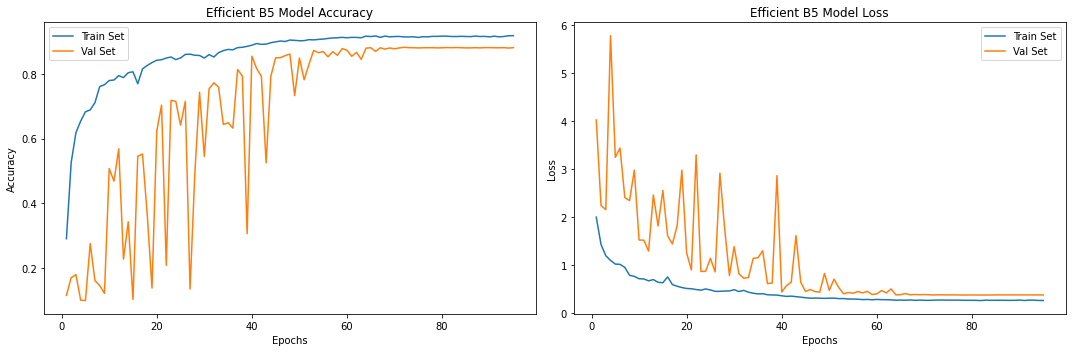

In [ ]:
train_val_loss(history_2)

### Model Evaluation Across All Datasets:

In [ ]:
best_model_path = "/gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_2-83-0.88.h5"
model_2 = load_model(best_model_path)

In [ ]:
evaluate_model(model_2, X_test, y_test, X_train, y_train, X_val, y_val)

1250/1250 [==============================] - 44s 35ms/step - loss: 0.1746 - accuracy: 0.9428
Training Accuracy: 94.28%
Training Loss: 0.17

313/313 [==============================] - 12s 38ms/step - loss: 0.3709 - accuracy: 0.8815
Validation Accuracy: 88.15%
Validation Loss: 0.37

313/313 [==============================] - 12s 38ms/step - loss: 0.3871 - accuracy: 0.8795
Test Accuracy: 87.95%
Test Loss: 0.39



### Plot Confusion Matrix -- Training:

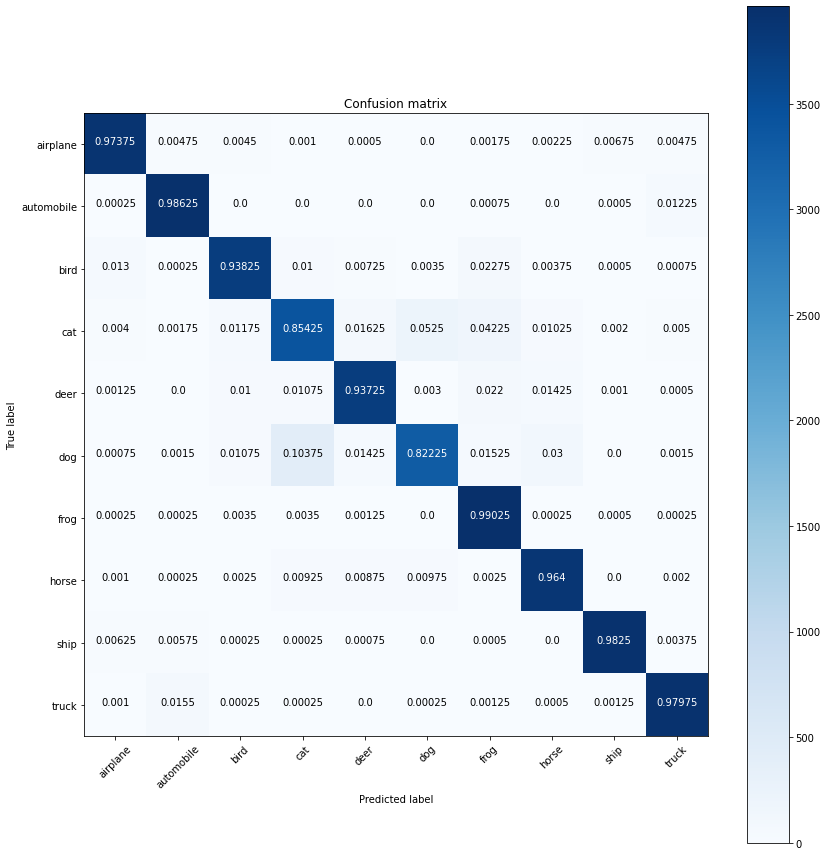

In [ ]:
#Display the confusion matrix for train set
Y_pred = model_2.predict(X_train, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_train, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

### Plot Confusion Matrix -- Validation:

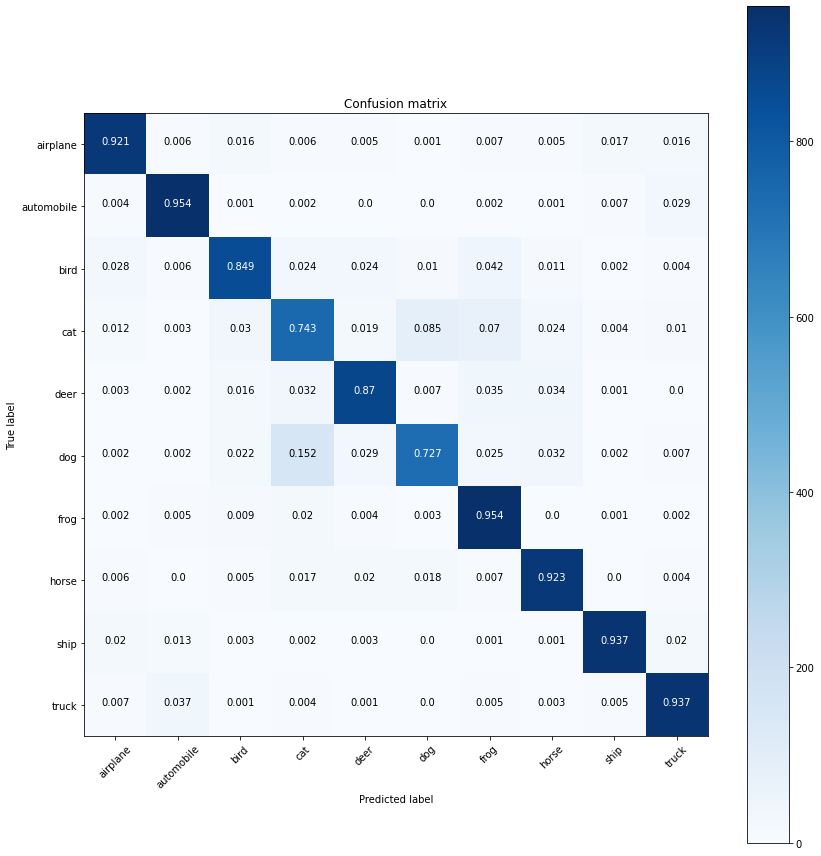

In [ ]:
#Display the confusion matrix for validation set
Y_pred = model_2.predict(X_val, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_val, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

### Plot Confusion Matrix -- Unseen Test Data:

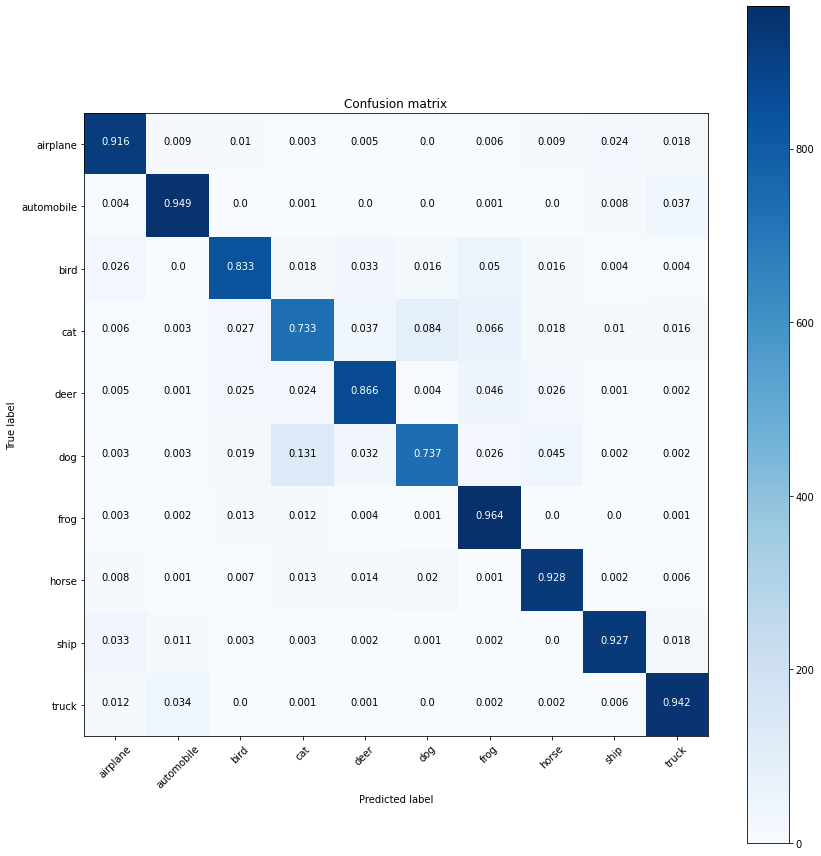

In [ ]:
#Display the confusion matrix for test set
Y_pred = model_2.predict(X_test, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_test, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

# Experiment : **3**

1. Same configuration as experiment 2. But here, we are adding regularization to all the fully connected layers instead of just the output layer.


### Define Model Hyperparameters:

In [ ]:
#Define the Hyperparameters for each models
input_params = dict()
input_params['EARLY_STOP_MONITOR'] = 'val_loss'
input_params['EARLY_STOP_MODE'] = 'min'
input_params['EARLY_STOP_PATIENCE'] = 10
input_params['REDUCE_LR_MONITOR'] = 'val_loss'
input_params['REDUCE_LR_MODE'] = 'min'
input_params['REDUCE_LR_PATIENCE'] = 4
input_params['REDUCE_LR_DECAY'] = 0.5
input_params['LR_SCHEDULER'] =  'None' #'LearningRateScheduler'  #'CosineAnnealing'
input_params['REDUCE_MIN_LR'] = 0.0000001
input_params['MINIBATCH_SIZE'] = 64
input_params['TRAIN_EPOCHS'] = 150
input_params['ACTIVATION_TYPE'] = "RELU" #'RELU'
input_params['NUM_CLASSES'] = NUM_CLASSES
input_params["MODEL_NUMBER"] = 3 #ExperimentNumber
input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] = 0.001
input_params["OPTIMIZER"] = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
input_params["CALLBACKS"] = callbacks_list(input_params)
input_params["EVAL_METRIC"] = 'accuracy'

### Define Model Architecture:

In [ ]:
def build_model_3(input_params):
    """
    This function is used to build the model architecture. Here I am adding 2 
    fully-connected layers to B5. We will modify this function to change the 
    model architecture during each training pass.
    """

    conv_base = EfficientNetB5(include_top=False, input_shape=(32,32,3), weights='imagenet')

    #Setting al layers trainable == True
    for layer in conv_base.layers:
        layer.trainable = True

    activation_type = 'relu'

    # Adding fully-connected layers to B5.
    x = conv_base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation=activation_type, kernel_regularizer = tf.keras.regularizers.L2(0.01))(x) 
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(256, activation=activation_type, kernel_regularizer = tf.keras.regularizers.L2(0.01))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation=activation_type, kernel_regularizer = tf.keras.regularizers.L2(0.01))(x)
    x = layers.Dropout(0.2)(x)  

    # Output layer
    prediction_layer = Dense(input_params['NUM_CLASSES'], activation="softmax", kernel_regularizer = tf.keras.regularizers.L2(0.01))(x)
    model_final = Model(inputs = conv_base.input, outputs = prediction_layer)

    # Define the optimizer and compile the model
    model_final.compile(loss='categorical_crossentropy', 
                        optimizer = input_params["OPTIMIZER"], 
                        metrics = input_params["EVAL_METRIC"])
    return model_final

model_3 = build_model_3(input_params)
model_3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 3)    7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 32, 32, 3)    0           ['normalization[0][0]']          
                                                                                              

 )                                                                                                
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 24)          0           ['block1c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block1c_se_reshape (Reshape)   (None, 1, 1, 24)     0           ['block1c_se_squeeze[0][0]']     
                                                                                                  
 block1c_se_reduce (Conv2D)     (None, 1, 1, 6)      150         ['block1c_se_reshape[0][0]']     
                                                                                                  
 block1c_se_expand (Conv2D)     (None, 1, 1, 24)     168         ['block1c_se_reduce[0][0]']      
          

 block2b_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block2b_se_reshape[0][0]']     
                                                                                                  
 block2b_se_expand (Conv2D)     (None, 1, 1, 240)    2640        ['block2b_se_reduce[0][0]']      
                                                                                                  
 block2b_se_excite (Multiply)   (None, 8, 8, 240)    0           ['block2b_activation[0][0]',     
                                                                  'block2b_se_expand[0][0]']      
                                                                                                  
 block2b_project_conv (Conv2D)  (None, 8, 8, 40)     9600        ['block2b_se_excite[0][0]']      
                                                                                                  
 block2b_project_bn (BatchNorma  (None, 8, 8, 40)    160         ['block2b_project_conv[0][0]']   
 lization)

                                                                  'block2d_se_expand[0][0]']      
                                                                                                  
 block2d_project_conv (Conv2D)  (None, 8, 8, 40)     9600        ['block2d_se_excite[0][0]']      
                                                                                                  
 block2d_project_bn (BatchNorma  (None, 8, 8, 40)    160         ['block2d_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2d_drop (Dropout)         (None, 8, 8, 40)     0           ['block2d_project_bn[0][0]']     
                                                                                                  
 block2d_add (Add)              (None, 8, 8, 40)     0           ['block2d_drop[0][0]',           
          

 block3a_project_conv (Conv2D)  (None, 4, 4, 64)     15360       ['block3a_se_excite[0][0]']      
                                                                                                  
 block3a_project_bn (BatchNorma  (None, 4, 4, 64)    256         ['block3a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_expand_conv (Conv2D)   (None, 4, 4, 384)    24576       ['block3a_project_bn[0][0]']     
                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 4, 4, 384)   1536        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_e

 block3d_expand_conv (Conv2D)   (None, 4, 4, 384)    24576       ['block3c_add[0][0]']            
                                                                                                  
 block3d_expand_bn (BatchNormal  (None, 4, 4, 384)   1536        ['block3d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3d_expand_activation (Act  (None, 4, 4, 384)   0           ['block3d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3d_dwconv (DepthwiseConv2  (None, 4, 4, 384)   9600        ['block3d_expand_activation[0][0]
 D)                                                              ']                               
          

 block4a_expand_activation (Act  (None, 4, 4, 384)   0           ['block4a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4a_dwconv_pad (ZeroPaddin  (None, 5, 5, 384)   0           ['block4a_expand_activation[0][0]
 g2D)                                                            ']                               
                                                                                                  
 block4a_dwconv (DepthwiseConv2  (None, 2, 2, 384)   3456        ['block4a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block4a_bn (BatchNormalization  (None, 2, 2, 384)   1536        ['block4a_dwconv[0][0]']         
 )        

 )                                                                                                
                                                                                                  
 block4c_activation (Activation  (None, 2, 2, 768)   0           ['block4c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4c_se_squeeze (GlobalAver  (None, 768)         0           ['block4c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4c_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4c_se_squeeze[0][0]']     
                                                                                                  
 block4c_s

 block4e_se_squeeze (GlobalAver  (None, 768)         0           ['block4e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4e_se_reshape (Reshape)   (None, 1, 1, 768)    0           ['block4e_se_squeeze[0][0]']     
                                                                                                  
 block4e_se_reduce (Conv2D)     (None, 1, 1, 32)     24608       ['block4e_se_reshape[0][0]']     
                                                                                                  
 block4e_se_expand (Conv2D)     (None, 1, 1, 768)    25344       ['block4e_se_reduce[0][0]']      
                                                                                                  
 block4e_se_excite (Multiply)   (None, 2, 2, 768)    0           ['block4e_activation[0][0]',     
          

 block4g_se_reduce (Conv2D)     (None, 1, 1, 32)     24608       ['block4g_se_reshape[0][0]']     
                                                                                                  
 block4g_se_expand (Conv2D)     (None, 1, 1, 768)    25344       ['block4g_se_reduce[0][0]']      
                                                                                                  
 block4g_se_excite (Multiply)   (None, 2, 2, 768)    0           ['block4g_activation[0][0]',     
                                                                  'block4g_se_expand[0][0]']      
                                                                                                  
 block4g_project_conv (Conv2D)  (None, 2, 2, 128)    98304       ['block4g_se_excite[0][0]']      
                                                                                                  
 block4g_project_bn (BatchNorma  (None, 2, 2, 128)   512         ['block4g_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block5b_drop (Dropout)         (None, 2, 2, 176)    0           ['block5b_project_bn[0][0]']     
                                                                                                  
 block5b_add (Add)              (None, 2, 2, 176)    0           ['block5b_drop[0][0]',           
                                                                  'block5a_project_bn[0][0]']     
                                                                                                  
 block5c_expand_conv (Conv2D)   (None, 2, 2, 1056)   185856      ['block5b_add[0][0]']            
                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 2, 2, 1056)  4224        ['block5c_expand_conv[0][0]']    
 ization) 

                                                                  'block5c_add[0][0]']            
                                                                                                  
 block5e_expand_conv (Conv2D)   (None, 2, 2, 1056)   185856      ['block5d_add[0][0]']            
                                                                                                  
 block5e_expand_bn (BatchNormal  (None, 2, 2, 1056)  4224        ['block5e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5e_expand_activation (Act  (None, 2, 2, 1056)  0           ['block5e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5e_d

 ization)                                                                                         
                                                                                                  
 block5g_expand_activation (Act  (None, 2, 2, 1056)  0           ['block5g_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5g_dwconv (DepthwiseConv2  (None, 2, 2, 1056)  26400       ['block5g_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5g_bn (BatchNormalization  (None, 2, 2, 1056)  4224        ['block5g_dwconv[0][0]']         
 )                                                                                                
          

                                                                                                  
 block6b_bn (BatchNormalization  (None, 1, 1, 1824)  7296        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 1, 1, 1824)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1824)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_s

 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1824)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6d_se_reduce[0][0]']      
          

 block6f_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6f_se_squeeze[0][0]']     
                                                                                                  
 block6f_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6f_se_reshape[0][0]']     
                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 1, 1, 1824)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
                                                                                                  
 block6f_project_conv (Conv2D)  (None, 1, 1, 304)    554496      ['block6f_se_excite[0][0]']      
          

                                                                                                  
 block6h_se_excite (Multiply)   (None, 1, 1, 1824)   0           ['block6h_activation[0][0]',     
                                                                  'block6h_se_expand[0][0]']      
                                                                                                  
 block6h_project_conv (Conv2D)  (None, 1, 1, 304)    554496      ['block6h_se_excite[0][0]']      
                                                                                                  
 block6h_project_bn (BatchNorma  (None, 1, 1, 304)   1216        ['block6h_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6h_drop (Dropout)         (None, 1, 1, 304)    0           ['block6h_project_bn[0][0]']     
          

                                                                                                  
 block7a_project_bn (BatchNorma  (None, 1, 1, 512)   2048        ['block7a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block7b_expand_conv (Conv2D)   (None, 1, 1, 3072)   1572864     ['block7a_project_bn[0][0]']     
                                                                                                  
 block7b_expand_bn (BatchNormal  (None, 1, 1, 3072)  12288       ['block7b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7b_expand_activation (Act  (None, 1, 1, 3072)  0           ['block7b_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 top_bn (BatchNormalization)    (None, 1, 1, 2048)   8192        ['top_conv[0][0]']               
                                                                                                  
 top_activation (Activation)    (None, 1, 1, 2048)   0           ['top_bn[0][0]']                 
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['top_activation[0][0]']         
 alAveragePooling2D)                                                                              
                                                                                                  
 dense (Dense)                  (None, 512)          1049088     ['global_average_pooling2d[0][0]'
                                                                 ]                                
          

### Define Model Augmentation Parameters:

In [ ]:
#The below Datagen layer will be used for Image Augmentation
datagen = ImageDataGenerator(featurewise_center=False,
                             samplewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_std_normalization=False,
                             zca_whitening=False,
                             rotation_range=15,
                             zoom_range = 0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False)

datagen.fit(X_train)

### Start Model Training:

In [ ]:
#Start model training
history_3 = model_3.fit_generator(datagen.flow(X_train, y_train, batch_size = input_params['MINIBATCH_SIZE']),
                                  steps_per_epoch = len(X_train) // input_params['MINIBATCH_SIZE'], 
                                  epochs = input_params['TRAIN_EPOCHS'],
                                  callbacks=input_params["CALLBACKS"],
                                  validation_data= (X_val, y_val),
                                  verbose=1)

C:\Users\sauga\AppData\Local\Temp\ipykernel_26204\3149413671.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_3 = model_3.fit_generator(datagen.flow(X_train, y_train, batch_size = input_params['MINIBATCH_SIZE']),


Epoch 1/150
625/625 [==============================] - ETA: 0s - loss: 3.6153 - accuracy: 0.3724
Epoch 1: saving model to G:/models\ENET_B5_Model_3-01-0.13.h5
625/625 [==============================] - 255s 353ms/step - loss: 3.6153 - accuracy: 0.3724 - val_loss: 3.6900 - val_accuracy: 0.1339 - lr: 0.0010
Epoch 2/150
625/625 [==============================] - ETA: 0s - loss: 1.4392 - accuracy: 0.6255
Epoch 2: saving model to G:/models\ENET_B5_Model_3-02-0.16.h5
625/625 [==============================] - 186s 298ms/step - loss: 1.4392 - accuracy: 0.6255 - val_loss: 2.9948 - val_accuracy: 0.1595 - lr: 0.0010
Epoch 3/150
625/625 [==============================] - ETA: 0s - loss: 1.2850 - accuracy: 0.6792
Epoch 3: saving model to G:/models\ENET_B5_Model_3-03-0.10.h5
625/625 [==============================] - 199s 319ms/step - loss: 1.2850 - accuracy: 0.6792 - val_loss: 2.6990 - val_accuracy: 0.1001 - lr: 0.0010
Epoch 4/150
625/625 [==============================] - ETA: 0s - loss: 1.2100 -

Epoch 27/150
625/625 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.9271
Epoch 27: saving model to G:/models\ENET_B5_Model_3-27-0.49.h5
625/625 [==============================] - 181s 290ms/step - loss: 0.3858 - accuracy: 0.9271 - val_loss: 2.1950 - val_accuracy: 0.4896 - lr: 1.2500e-04
Epoch 28/150
625/625 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.9271
Epoch 28: saving model to G:/models\ENET_B5_Model_3-28-0.67.h5
625/625 [==============================] - 180s 287ms/step - loss: 0.3845 - accuracy: 0.9271 - val_loss: 1.3029 - val_accuracy: 0.6748 - lr: 1.2500e-04
Epoch 29/150
625/625 [==============================] - ETA: 0s - loss: 0.3728 - accuracy: 0.9309
Epoch 29: saving model to G:/models\ENET_B5_Model_3-29-0.63.h5

Epoch 29: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
625/625 [==============================] - 182s 290ms/step - loss: 0.3728 - accuracy: 0.9309 - val_loss: 1.5866 - val_accuracy: 0.6305 -

625/625 [==============================] - 206s 329ms/step - loss: 0.2823 - accuracy: 0.9516 - val_loss: 0.5452 - val_accuracy: 0.8802 - lr: 1.5625e-05
Epoch 53/150
625/625 [==============================] - ETA: 0s - loss: 0.2893 - accuracy: 0.9502
Epoch 53: saving model to G:/models\ENET_B5_Model_3-53-0.89.h5
625/625 [==============================] - 187s 299ms/step - loss: 0.2893 - accuracy: 0.9502 - val_loss: 0.4819 - val_accuracy: 0.8940 - lr: 1.5625e-05
Epoch 54/150
625/625 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.9508
Epoch 54: saving model to G:/models\ENET_B5_Model_3-54-0.89.h5

Epoch 54: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
625/625 [==============================] - 206s 330ms/step - loss: 0.2832 - accuracy: 0.9508 - val_loss: 0.5022 - val_accuracy: 0.8897 - lr: 1.5625e-05
Epoch 55/150
625/625 [==============================] - ETA: 0s - loss: 0.2842 - accuracy: 0.9516
Epoch 55: saving model to G:/models\ENET_B5_Mo

### Train vs Validation (Loss and Accuracy Graphs):

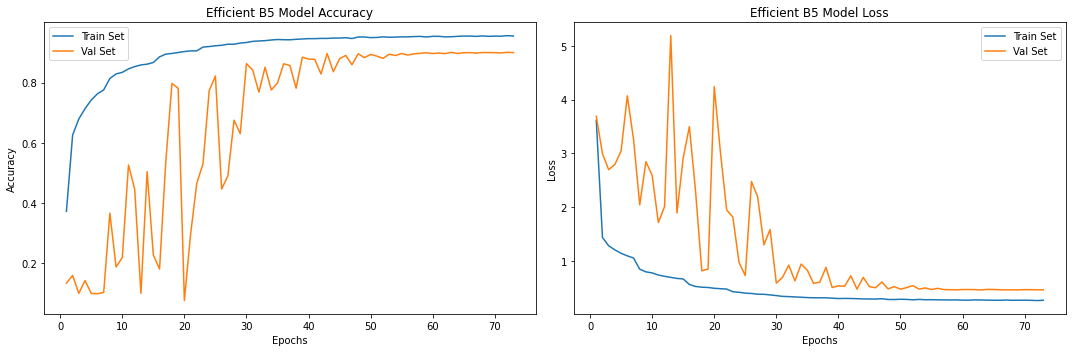

In [ ]:
train_val_loss(history_3)

### Model Evaluation Across All Datasets:

In [ ]:
#Load the saved model
best_model_path = "/gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_3-57-0.90.h5"
model_3 = load_model(best_model_path)

In [ ]:
evaluate_model(model_3, X_test, y_test, X_train, y_train, X_val, y_val)

1250/1250 [==============================] - 69s 51ms/step - loss: 0.2039 - accuracy: 0.9736
Training Accuracy: 97.36%
Training Loss: 0.2

313/313 [==============================] - 21s 53ms/step - loss: 0.4730 - accuracy: 0.8952
Validation Accuracy: 89.52%
Validation Loss: 0.47

313/313 [==============================] - 17s 54ms/step - loss: 0.4865 - accuracy: 0.8894
Test Accuracy: 88.94%
Test Loss: 0.49



### Plot Confusion Matrix -- Training:

625/625 [==============================] - 49s 65ms/step


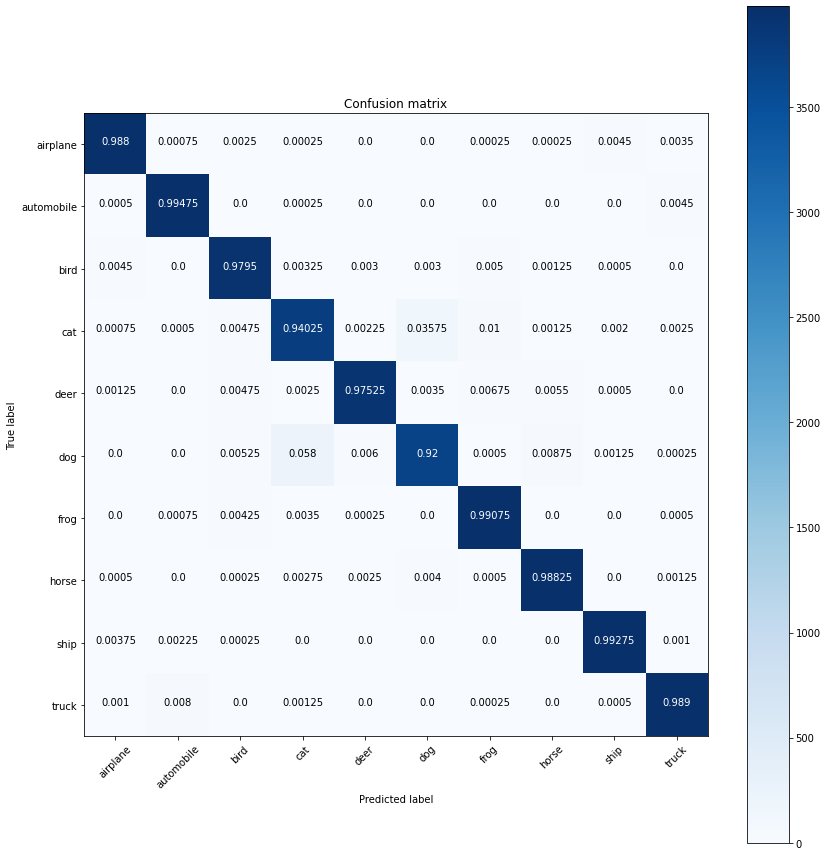

In [ ]:
#Display the confusion matrix for train set
Y_pred = model_3.predict(X_train, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_train, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

### Plot Confusion Matrix -- Validation:

157/157 [==============================] - 17s 74ms/step


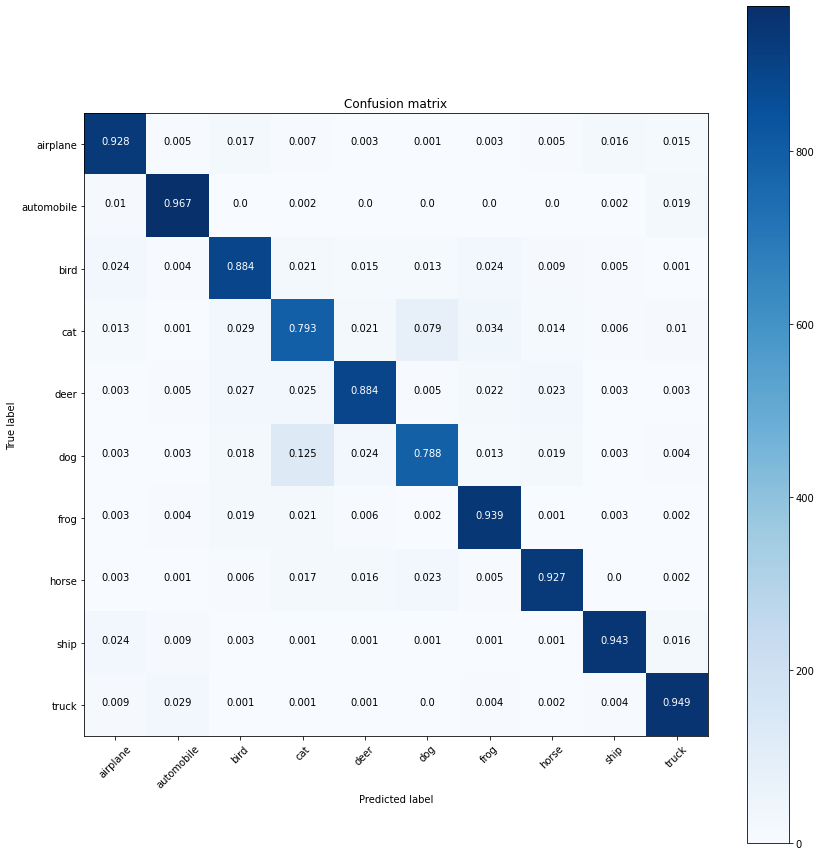

In [ ]:
#Display the confusion matrix for validation set
Y_pred = model_3.predict(X_val, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_val, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

### Plot Confusion Matrix -- Unseen Test Data:

157/157 [==============================] - 10s 63ms/step


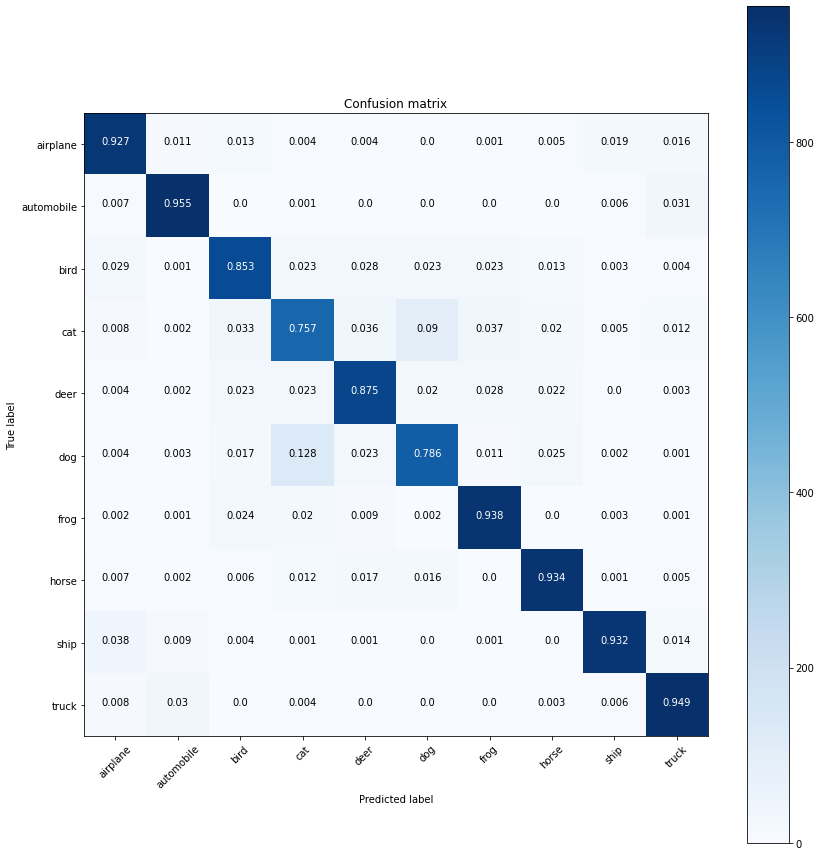

In [ ]:
#Display the confusion matrix for test set
Y_pred = model_3.predict(X_test, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_test, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

# Experiment : **4**

1. Adding both L1 L2 to the dense fully connected layers as well as the efficient net convolution layers 
2. Adding a new fully connected layer and adjust the dropouts
3. Adding a very small decay factor in the Adam optimizer
4. Using a lower learning rate than previous experiments

### Define Model Hyperparameters:

In [ ]:
#Define the Hyperparameters for each models
input_params = dict()
input_params['EARLY_STOP_MONITOR'] = 'val_loss'
input_params['EARLY_STOP_MODE'] = 'min'
input_params['EARLY_STOP_PATIENCE'] = 12
input_params['REDUCE_LR_MONITOR'] = 'val_loss'
input_params['REDUCE_LR_MODE'] = 'min'
input_params['REDUCE_LR_PATIENCE'] = 4
input_params['REDUCE_LR_DECAY'] = 0.5
input_params['LR_SCHEDULER'] =  'None' #'LearningRateScheduler'  #'CosineAnnealing'
input_params['REDUCE_MIN_LR'] = 0.0000001
input_params['MINIBATCH_SIZE'] = 128
input_params['TRAIN_EPOCHS'] = 150
input_params['ACTIVATION_TYPE'] = "RELU" #'RELU'
input_params['NUM_CLASSES'] = NUM_CLASSES
input_params["MODEL_NUMBER"] = 4 #ExperimentNumber
input_params["TRAIN_OPTIMIZER_LEARNING_RATE"] = 0.005
input_params["OPTIMIZER"] = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
input_params["CALLBACKS"] = callbacks_list(input_params)
input_params["EVAL_METRIC"] = 'accuracy'

### Define Model Architecture:

In [ ]:
def build_model_4(input_params):
    """
    This function is used to build the model architecture. Here I am adding 2 
    fully-connected layers to B5. We will modify this function to change the 
    model architecture during each training pass.
    """
    #kernel_regularizer = tf.keras.regularizers.l1(0.01)

    conv_base = EfficientNetB5(include_top=False, input_shape=(32,32,3), weights='imagenet')

    #Setting al layers trainable == True
    for layer in conv_base.layers:
        layer.trainable = True

    activation_type = 'relu'

    # Adding fully-connected with dropout layers to B5.
    x = conv_base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation = activation_type)(x) 
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(256, activation = activation_type)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation = activation_type)(x)
    x = layers.Dropout(0.3)(x)  
    x = layers.Dense(64, activation = activation_type)(x)
    x = layers.Dropout(0.2)(x)  

    # Output layer
    prediction_layer = Dense(input_params['NUM_CLASSES'], activation="softmax", kernel_regularizer = tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
    model_final = Model(inputs = conv_base.input, outputs = prediction_layer)

    # Define the optimizer and compile the model
    model_final.compile(loss='categorical_crossentropy', 
                        optimizer = input_params["OPTIMIZER"], 
                        metrics = input_params["EVAL_METRIC"])
    return model_final

def add_regularization(model, regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)):
    """
    This function is used to add L1L2 penalty to both kernel_regularizer
    and bias_regularizer across all layers. When we change the layers 
    attributes, the change only happens in the model config file. Save 
    the weights before reloading the model. Load the model from the config.
    Reload the model weights.
    """

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return model

    for layer in model.layers:
        for attr in ['kernel_regularizer', 'bias_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    model_json = model.to_json()
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights.h5')
    model.save_weights(tmp_weights_path)
    model = tf.keras.models.model_from_json(model_json)
    model.load_weights(tmp_weights_path, by_name=True)
    return model

def unfreeze_top_layers(model, input_params):
    # We unfreeze the top 100 layers while leaving base layers frozen
    for layer in model.layers[-500:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    model.compile(optimizer=input_params["OPTIMIZER"], loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model_4 = build_model_4(input_params)
#model_4 = unfreeze_top_layers(model_4, input_params)
model_4 = add_regularization(model_4) #Adding regularizer to the layers
model_4.compile(loss='categorical_crossentropy', optimizer = input_params["OPTIMIZER"], metrics = input_params["EVAL_METRIC"])
model_4.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling_2 (Rescaling)        (None, 32, 32, 3)    0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 32, 32, 3)   7           ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 33, 33, 3)    0           ['normalization_2[0][0]']  

### Define Model Augmentation Parameters:

In [ ]:
#The below ImageDataGenerator layer will be used for Image Augmentation
datagen = ImageDataGenerator(featurewise_center=False,
                            samplewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            zca_whitening=False,
                            rotation_range=20,
                            zoom_range = 0.15,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            horizontal_flip=True,
                            vertical_flip=True)

datagen.fit(X_train)

### Start Model Training:

In [ ]:
#Start model training
history_4 = model_4.fit_generator(datagen.flow(X_train, y_train, batch_size = input_params['MINIBATCH_SIZE']),
                                  steps_per_epoch = len(X_train) // input_params['MINIBATCH_SIZE'], 
                                  epochs = input_params['TRAIN_EPOCHS'],
                                  callbacks=input_params["CALLBACKS"],
                                  validation_data= (X_val, y_val),
                                  verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/150
312/312 [==============================] - ETA: 0s - loss: 14.7919 - accuracy: 0.1543
Epoch 1: saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_4-01-0.12.h5
312/312 [==============================] - 134s 269ms/step - loss: 14.7919 - accuracy: 0.1543 - val_loss: 12.7315 - val_accuracy: 0.1150 - lr: 5.0000e-04
Epoch 2/150
312/312 [==============================] - ETA: 0s - loss: 11.0047 - accuracy: 0.2532
Epoch 2: saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_4-02-0.15.h5
312/312 [==============================] - 74s 237ms/step - loss: 11.0047 - accuracy: 0.2532 - val_loss: 10.1220 - val_accuracy: 0.1480 - lr: 5.0000e-04
Epoch 3/150
312/312 [==============================] - ETA: 0s - loss: 8.6649 - accuracy: 0.3568
Epoch 3: saving model to /gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_4-03-0.16.h5
312/312 [==============================] - 73s 234ms/step - loss: 8.6649 - accuracy: 0.3568 - val_loss: 8.5007 - val_accuracy: 0.1558 - lr: 5.000

### Train vs Validation (Loss and Accuracy Graphs):

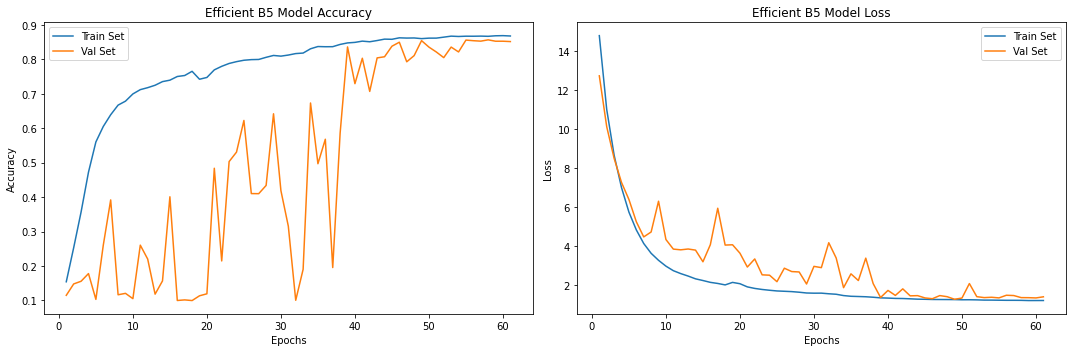

In [ ]:
train_val_loss(history_4)

### Model Evaluation Across All Datasets:

In [13]:
best_model_path = "/gdrive/My Drive/CIFAR-10-MODELS/ENET_B5_Model_4-58-0.86.h5"
model_4 = load_model(best_model_path)

In [14]:
evaluate_model(model_4, X_test, y_test, X_train, y_train, X_val, y_val)

1250/1250 [==============================] - 310s 241ms/step - loss: 1.1778 - accuracy: 0.9039
Training Accuracy: 90.39%
Training Loss: 1.18

313/313 [==============================] - 80s 226ms/step - loss: 1.3591 - accuracy: 0.8565
Validation Accuracy: 85.65%
Validation Loss: 1.36

313/313 [==============================] - 71s 226ms/step - loss: 1.3662 - accuracy: 0.8455
Test Accuracy: 84.55%
Test Loss: 1.37



### Plot Confusion Matrix -- Training:

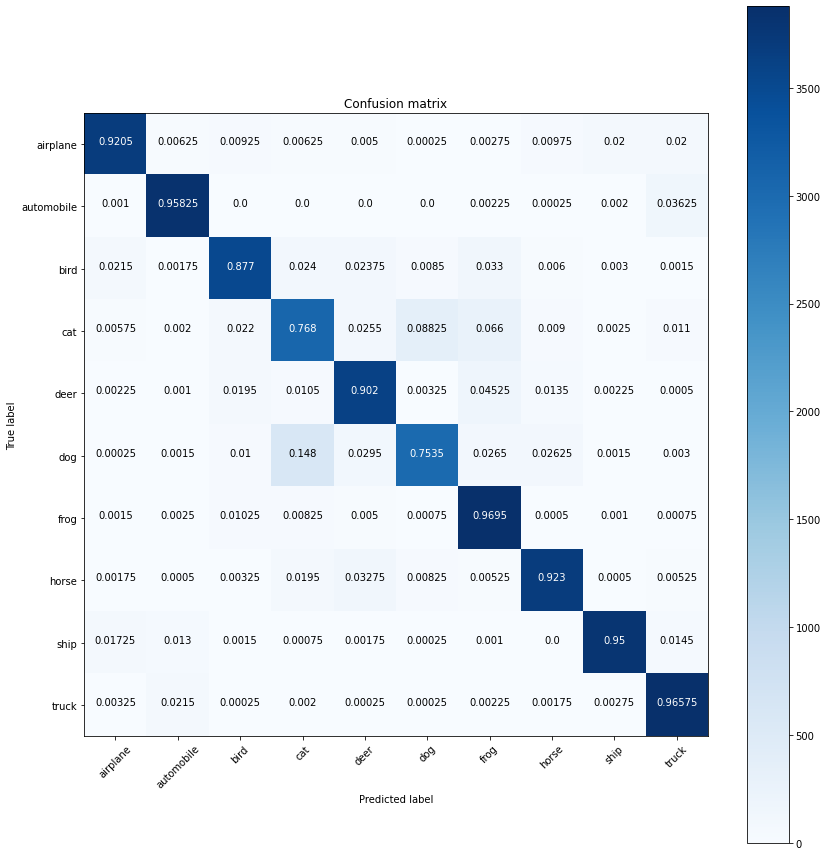

In [ ]:
#Display the confusion matrix for train set
Y_pred = model_4.predict(X_train, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_train, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

### Plot Confusion Matrix -- Validation:

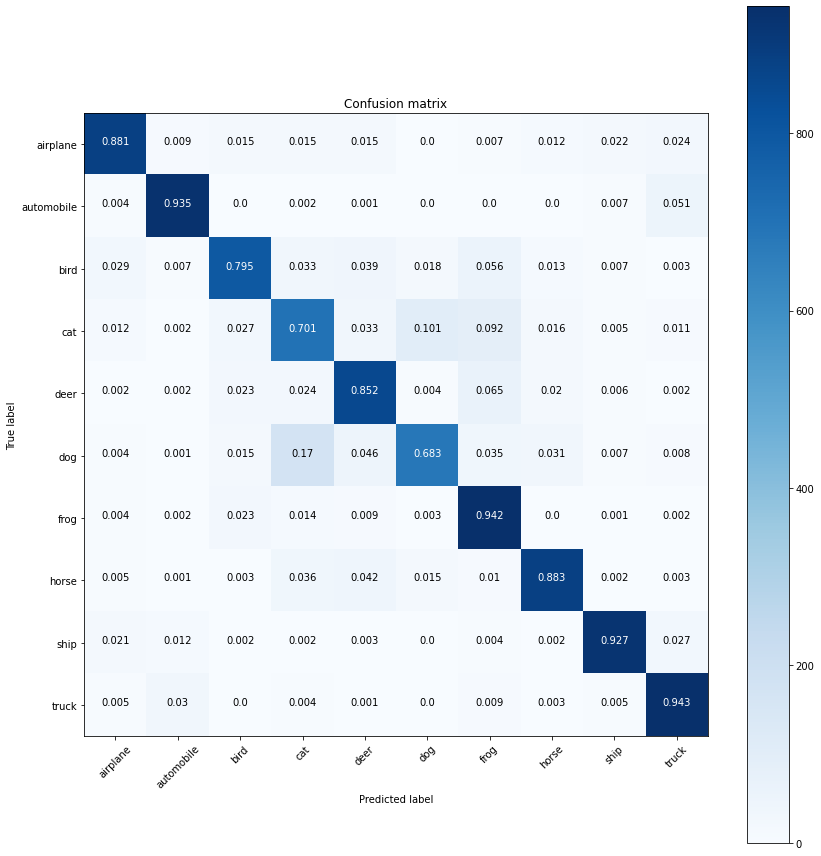

In [ ]:
#Display the confusion matrix for validation set
Y_pred = model_4.predict(X_val, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_val, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

### Plot Confusion Matrix -- Unseen Test Data:

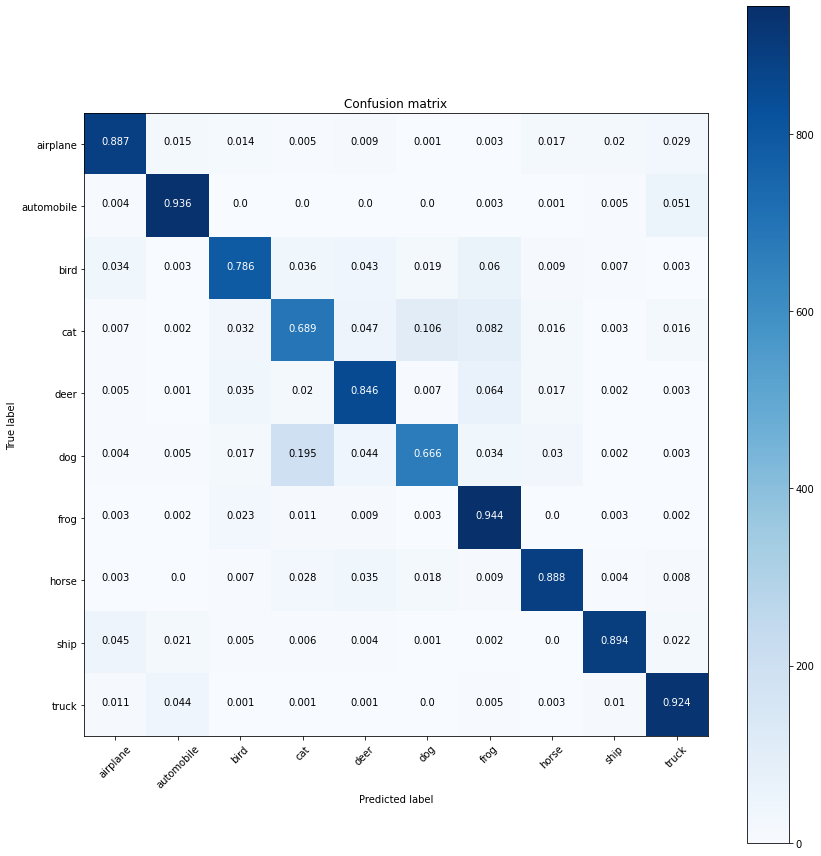

In [ ]:
#Display the confusion matrix for test set
Y_pred = model_4.predict(X_test, batch_size=input_params['MINIBATCH_SIZE'])
Y_pred_classes = np.argmax(Y_pred,axis=1) 
rounded_labels=np.argmax(y_test, axis=1)
cm_matrix = confusion_matrix(rounded_labels, Y_pred_classes)
plot_cm(cm_matrix, normalize=True, classes = range(len(class_label_list)), LABELS=class_label_list)

# Results

In [15]:
from prettytable import PrettyTable

myTable = PrettyTable(["Experiment Name", "Train Loss", "Validation Loss", "Test Loss", "Train Accuracy", "Validation Accuracy", "Test Accuracy" ])
myTable.add_row(["Experiment 1", "0.33", "0.45", "0.47", "89.2%", "85.34%", "85.11%"])
myTable.add_row(["Experiment 2", "0.17", "0.37", "0.39", "94.28%", "88.15%", "87.95%"])
myTable.add_row(["Experiment 3", "0.20", "0.47", "0.49", "97.36%", "89.52%", "88.94%"])
myTable.add_row(["Experiment 4", "1.18", "1.36", "1.37", "90.39", "85.65%", "84.55%"])  
print(myTable)

+-----------------+------------+-----------------+-----------+----------------+---------------------+---------------+
| Experiment Name | Train Loss | Validation Loss | Test Loss | Train Accuracy | Validation Accuracy | Test Accuracy |
+-----------------+------------+-----------------+-----------+----------------+---------------------+---------------+
|   Experiment 1  |    0.33    |       0.45      |    0.47   |     89.2%      |        85.34%       |     85.11%    |
|   Experiment 2  |    0.17    |       0.37      |    0.39   |     94.28%     |        88.15%       |     87.95%    |
|   Experiment 3  |    0.20    |       0.47      |    0.49   |     97.36%     |        89.52%       |     88.94%    |
|   Experiment 4  |    1.18    |       1.36      |    1.37   |     90.39      |        85.65%       |     84.55%    |
+-----------------+------------+-----------------+-----------+----------------+---------------------+---------------+


# Key Observations

1. For experiment 1, I have selected the model at the 29th epoch, after which the model accuracy on validation data remains constant. There is a significant improve in model performance from version 1. A 3.86% difference is observed between the train and validation set, and 4% between the train and test set. This indicates that the overfitting has been reduced considerably

2. For experiment 2, adding L2 regularizer to the last fully connected layers and tweaking the augmentation strategy by introducing zoom, increased all the train, validation and test accuracies. I have selected the model generated at epoch 83, post which there's no significant difference observed in model accuracy. There's a 6.13% difference in error observed between train and validation accuracies. This implies that overfitting has increased in experiment 2, from experiment 1.

3. For experiment 3, I have added regularization to all the fully connected layers and trained the model. The gap between train and validation error has now increased to almost 7%, which suggests significant overfitting than experiment 1.

4. For experiment 4, I have added both L1 and L2 regularizer for both the convolution layers as well as the convolution layers of efficient net. Tweaked the augmentation paparemeters more. I have also tried to freeze the convolution base and unfreeze only the top 20 layers. However, the accuracy was constant at 10% afte rmany epochs. Tried changing many hyperparameters, but there's no real effect. That's the reason I have not included the experiment in this notebook.

# Key Takeaway

If we look at all the experiments, experiment 1 has generated the least overfitted model after training for only 29 epochs (early stopped). The difference between train and validation dataset is 3.86%, which indicates slight overftting. On close observation we also notice that the train and validation loss are very very similar to each other (about 0.44 value for both losses), which indicates the model will generalize well on unseen data points. For a custom architecture, we could also have used SpatialDropout to tackle overfitting more. For the pre-trained architecture, I need more time and many more iterations to successfully integrate SpatialDropout.